In [46]:
import pandas as pd
import numpy as np
import requests
import json
import os
from dotenv import load_dotenv
import folium
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools, algorithms
import random
from geopy.distance import geodesic
import warnings
import joblib
from folium.plugins import MarkerCluster
import polyline
warnings.filterwarnings('ignore')


load_dotenv()


MAPMYINDIA_API_KEY = os.getenv('MAPMYINDIA_API_KEY')
WEATHER_API_KEY = os.getenv('WEATHER_API_KEY')
GOOGLE_MAPS_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')

print("Environment loaded successfully!")

Environment loaded successfully!


In [45]:
!pip install polyline


  Using cached polyline-2.0.2-py3-none-any.whl.metadata (6.4 kB)
Using cached polyline-2.0.2-py3-none-any.whl (6.0 kB)


In [21]:
df = pd.read_excel('../data/Starbucks_Mumbai_Dataset.xlsx')

print(f"Dataset shape: {df.shape}")
print("\nDataset columns:")
print(df.columns.tolist())

df = df.dropna(subset=['Latitude', 'Longitude'])
df['store_id'] = df.index

df_clean = df[['store_id', 'Store Name', 'Latitude', 'Longitude', 
               'Street Address', 'City', 'State']].copy()

print(f"\nCleaned dataset shape: {df_clean.shape}")
print("\nSample locations:")
df_clean.head()


Dataset shape: (32, 13)

Dataset columns:
['Brand', 'Store Number', 'Store Name', 'Ownership Type', 'Street Address', 'City', 'State', 'Country', 'Pincode', 'Phone Number', 'Timezone', 'Longitude', 'Latitude']

Cleaned dataset shape: (32, 7)

Sample locations:


,store_id,Store Name,Latitude,Longitude,Street Address,City,State
0,0,Prabhadevi,19.01,72.82,"Upper Ground Floor, Century Bhavan, Century Ba...",Mumbai,MH
1,1,Malad West - Infiniti Mall,19.18,72.83,"Upper Ground Floor, Infiniti Mall, Link Road, ...",Mumbai,MH
2,2,Santacruz West,19.08,72.83,"Grd Flr Red Chillies Entertainment Bldg, Jct o...",Mumbai,MH
3,3,Nariman Point,18.93,72.82,"Ground Floor, Shree Nirmal Building, Behind Tr...",Mumbai,MH
4,4,Andheri West - Four Bunglows,19.13,72.82,"Kokilaben Dhirubhai Ambani Hospital, Four Bung...",Mumbai,MH


In [22]:
def get_weather_data(lat, lon):
    """Get current weather data from weatherapi.com"""
    base_url = "http://api.weatherapi.com/v1/current.json"
    
    params = {
        'key': WEATHER_API_KEY,
        'q': f"{lat},{lon}",
        'aqi': 'yes'
    }
    
    try:
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            weather_info = {
                'temperature': data['current']['temp_c'],
                'humidity': data['current']['humidity'],
                'wind_speed': data['current']['wind_kph'],
                'condition': data['current']['condition']['text'],
                'visibility': data['current']['vis_km'],
                'precipitation': data['current']['precip_mm']
            }
            return weather_info
    except Exception as e:
        print(f"Weather API error: {e}")
    
    return {
        'temperature': 28.0,
        'humidity': 75.0,
        'wind_speed': 10.0,
        'condition': 'Clear',
        'visibility': 10.0,
        'precipitation': 0.0
    }

def get_travel_time_distance(origin_lat, origin_lon, dest_lat, dest_lon, departure_time='now'):
    """Get travel time and distance using Google Distance Matrix API"""
    base_url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    
    params = {
        'origins': f"{origin_lat},{origin_lon}",
        'destinations': f"{dest_lat},{dest_lon}",
        'mode': 'driving',
        'departure_time': departure_time,
        'traffic_model': 'best_guess',
        'key': GOOGLE_MAPS_API_KEY
    }
    
    try:
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            if data['status'] == 'OK':
                element = data['rows'][0]['elements'][0]
                if element['status'] == 'OK':
                    return {
                        'distance': element['distance']['value'] / 1000,  # km
                        'duration': element['duration']['value'] / 60,    # minutes
                        'duration_in_traffic': element.get('duration_in_traffic', {}).get('value', element['duration']['value']) / 60
                    }
    except Exception as e:
        print(f"Distance Matrix API error: {e}")
    
    distance = geodesic((origin_lat, origin_lon), (dest_lat, dest_lon)).km
    return {
        'distance': distance,
        'duration': distance * 2.5,  
        'duration_in_traffic': distance * 3.0  
    }

print("API functions defined successfully!")

API functions defined successfully!


In [49]:
def get_directions_route(origin_lat, origin_lon, dest_lat, dest_lon):
    """Get actual driving route using Google Directions API with enhanced error handling"""
    base_url = "https://maps.googleapis.com/maps/api/directions/json"
    
    params = {
        'origin': f"{origin_lat},{origin_lon}",
        'destination': f"{dest_lat},{dest_lon}",
        'mode': 'driving',
        'departure_time': 'now',
        'traffic_model': 'best_guess',
        'key': GOOGLE_MAPS_API_KEY
    }
    
    try:
        response = requests.get(base_url, params=params, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            
            # Debug: Print the status
            if data['status'] != 'OK':
                print(f"API Status: {data['status']}")
                if 'error_message' in data:
                    print(f"Error: {data['error_message']}")
                return None
            
            if data['routes']:
                route = data['routes'][0]
                
                # Get the overview polyline for the entire route
                overview_polyline = route['overview_polyline']['points']
                
                # Decode polyline to get all route points
                route_points = decode_polyline(overview_polyline)
                
                # Also get all detailed points from steps
                all_points = []
                for leg in route['legs']:
                    for step in leg['steps']:
                        step_points = decode_polyline(step['polyline']['points'])
                        all_points.extend(step_points)
                
                # Use detailed points if available, otherwise use overview
                final_route_points = all_points if all_points else route_points
                
                return {
                    'route_points': final_route_points,
                    'overview_polyline': overview_polyline,
                    'distance': route['legs'][0]['distance']['value'] / 1000,  # km
                    'duration': route['legs'][0]['duration']['value'] / 60,    # minutes
                    'bounds': route['bounds'],
                    'legs': route['legs']
                }
        else:
            print(f"HTTP Error: {response.status_code}")
            
    except Exception as e:
        print(f"Directions API error: {str(e)}")
    
    return None


In [30]:
def generate_training_data(df_locations, num_samples=500, starting_point_input=None):
    """
    Generate training data with various origin-destination pairs
    Including routes from a starting point if provided
    """
    training_data = []
    
    # Default starting point (can be warehouse, depot, etc.)
    if starting_point_input is None:
        # Use a central Mumbai location as default starting point
        starting_point_input = {'lat': 19.0760, 'lon': 72.8777}  # Mumbai center
    
    print(f"Generating {num_samples} training samples...")
    print(f"Starting point: ({starting_point_input['lat']}, {starting_point_input['lon']})")
    
    for i in range(num_samples):
        # Mix of different route types
        route_type = np.random.choice(['location_to_location', 'from_start', 'to_start'], 
                                     p=[0.6, 0.2, 0.2])
        
        if route_type == 'location_to_location':
            # Regular location to location
            origin_idx = np.random.randint(0, len(df_locations))
            dest_idx = np.random.randint(0, len(df_locations))
            
            if origin_idx == dest_idx:
                continue
            
            origin = df_locations.iloc[origin_idx]
            destination = df_locations.iloc[dest_idx]
            
            origin_lat = origin['Latitude']
            origin_lon = origin['Longitude']
            dest_lat = destination['Latitude']
            dest_lon = destination['Longitude']
            
        elif route_type == 'from_start':
            # From starting point to a location
            dest_idx = np.random.randint(0, len(df_locations))
            destination = df_locations.iloc[dest_idx]
            
            origin_lat = starting_point_input['lat']
            origin_lon = starting_point_input['lon']
            dest_lat = destination['Latitude']
            dest_lon = destination['Longitude']
            
        else:  # to_start
            # From a location to starting point
            origin_idx = np.random.randint(0, len(df_locations))
            origin = df_locations.iloc[origin_idx]
            
            origin_lat = origin['Latitude']
            origin_lon = origin['Longitude']
            dest_lat = starting_point_input['lat']
            dest_lon = starting_point_input['lon']
        
        # Get weather data for origin
        weather = get_weather_data(origin_lat, origin_lon)
        
        # Get travel time and distance
        travel_info = get_travel_time_distance(
            origin_lat, origin_lon,
            dest_lat, dest_lon
        )
        
        # Create feature vector
        feature_dict = {
            'origin_lat': origin_lat,
            'origin_lon': origin_lon,
            'dest_lat': dest_lat,
            'dest_lon': dest_lon,
            'straight_line_distance': geodesic(
                (origin_lat, origin_lon),
                (dest_lat, dest_lon)
            ).km,
            'temperature': weather['temperature'],
            'humidity': weather['humidity'],
            'wind_speed': weather['wind_speed'],
            'visibility': weather['visibility'],
            'precipitation': weather['precipitation'],
            'hour_of_day': datetime.now().hour,
            'day_of_week': datetime.now().weekday(),
            'actual_distance': travel_info['distance'],
            'travel_time': travel_info['duration_in_traffic']
        }
        
        training_data.append(feature_dict)
        
        # Progress update
        if (i + 1) % 50 == 0:
            print(f"Generated {i + 1}/{num_samples} samples")
        
        # Respect API rate limits
        if i % 10 == 0:
            time.sleep(1)
    
    return pd.DataFrame(training_data)

# Generate training data with a starting point
# You can change this to any starting point you want
starting_point = {'lat': 19.197390924721947, 'lon': 72.99068873350765}  # Mumbai center as example  
training_df = generate_training_data(df_clean, num_samples=300, starting_point_input=starting_point)

# Save training data
training_df.to_csv('../data/training_data.csv', index=False)
print(f"\nTraining data shape: {training_df.shape}")
print("\nTraining data summary:")
training_df.describe()

         
     


Generating 300 training samples...
Starting point: (19.197390924721947, 72.99068873350765)
Generated 50/300 samples
Generated 100/300 samples
Generated 200/300 samples
Generated 250/300 samples
Generated 300/300 samples

Training data shape: (289, 14)

Training data summary:


,origin_lat,origin_lon,dest_lat,dest_lon,straight_line_distance,temperature,humidity,wind_speed,visibility,precipitation,hour_of_day,day_of_week,actual_distance,travel_time
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.0,289.000000,2.890000e+02,289.000000,289.0,289.0,289.000000,289.000000
mean,19.108825,72.888010,19.106622,72.882694,15.278139,26.006228,94.0,32.091349,1.800000e+00,0.783702,21.0,2.0,15.278139,45.834416
std,0.081803,0.065687,0.085799,0.065086,8.612156,0.042849,0.0,3.299110,2.224298e-16,0.260929,0.0,0.0,8.612156,25.836468
min,18.920000,72.810000,18.920000,72.810000,1.052542,26.000000,94.0,28.100000,1.800000e+00,0.530000,21.0,2.0,1.052542,3.157626
25%,19.060000,72.830000,19.060000,72.830000,8.855337,26.000000,94.0,28.100000,1.800000e+00,0.530000,21.0,2.0,8.855337,26.566011
50%,19.100000,72.860000,19.110000,72.860000,15.365461,26.000000,94.0,32.000000,1.800000e+00,0.810000,21.0,2.0,15.365461,46.096384
75%,19.197391,72.970000,19.197391,72.970000,19.540118,26.000000,94.0,35.600000,1.800000e+00,0.810000,21.0,2.0,19.540118,58.620353
max,19.210000,72.990689,19.210000,72.990689,35.055191,26.300000,94.0,35.600000,1.800000e+00,1.210000,21.0,2.0,35.055191,105.165573


In [31]:
feature_columns = ['origin_lat', 'origin_lon', 'dest_lat', 'dest_lon',
                  'straight_line_distance', 'temperature', 'humidity',
                  'wind_speed', 'visibility', 'precipitation',
                  'hour_of_day', 'day_of_week']

X = training_df[feature_columns]
y = training_df['travel_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training XGBoost model...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist'
)

xgb_model.fit(X_train_scaled, y_train)

y_pred = xgb_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"\nModel Performance:")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.2f} minutes")
print(f"Mean Absolute Error: {np.mean(np.abs(y_test - y_pred)):.2f} minutes")

joblib.dump(xgb_model, '../models/travel_time_predictor.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
print("\nModel saved successfully!")


Training XGBoost model...

Model Performance:
R² Score: 0.999
RMSE: 0.57 minutes
Mean Absolute Error: 0.26 minutes

Model saved successfully!


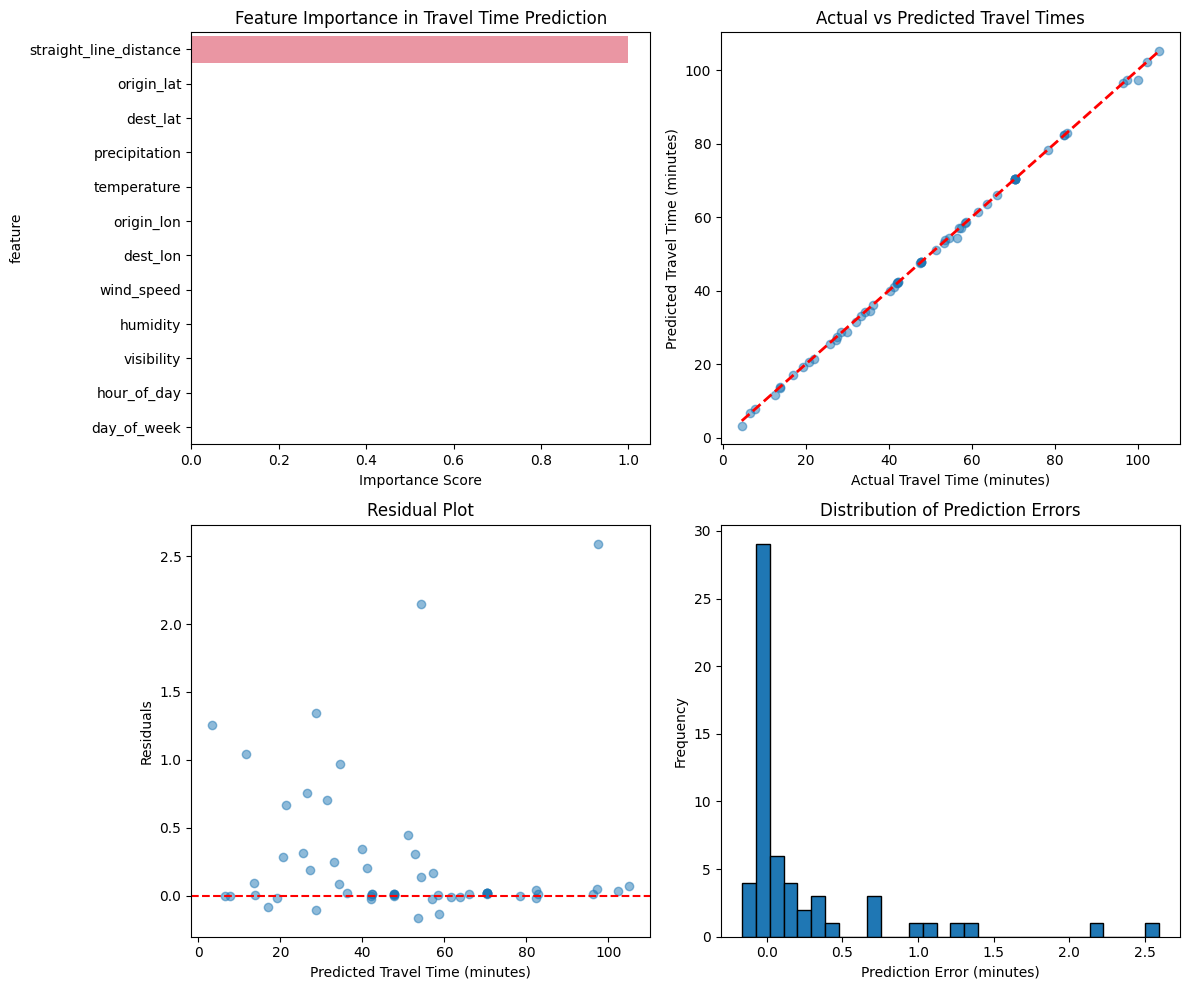

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

ax1 = axes[0, 0]
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance, x='importance', y='feature', ax=ax1)
ax1.set_title('Feature Importance in Travel Time Prediction')
ax1.set_xlabel('Importance Score')

ax2 = axes[0, 1]
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Travel Time (minutes)')
ax2.set_ylabel('Predicted Travel Time (minutes)')
ax2.set_title('Actual vs Predicted Travel Times')

ax3 = axes[1, 0]
residuals = y_test - y_pred
ax3.scatter(y_pred, residuals, alpha=0.5)
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_xlabel('Predicted Travel Time (minutes)')
ax3.set_ylabel('Residuals')
ax3.set_title('Residual Plot')

ax4 = axes[1, 1]
ax4.hist(residuals, bins=30, edgecolor='black')
ax4.set_xlabel('Prediction Error (minutes)')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Prediction Errors')

plt.tight_layout()
plt.savefig('../data/xgboost_performance.png', dpi=300, bbox_inches='tight')
plt.show()


In [33]:
def predict_travel_time(origin_coords, dest_coords, model, scaler):

    weather = get_weather_data(origin_coords[0], origin_coords[1])

    straight_distance = geodesic(origin_coords, dest_coords).km
    
    features = {
        'origin_lat': origin_coords[0],
        'origin_lon': origin_coords[1],
        'dest_lat': dest_coords[0],
        'dest_lon': dest_coords[1],
        'straight_line_distance': straight_distance,
        'temperature': weather['temperature'],
        'humidity': weather['humidity'],
        'wind_speed': weather['wind_speed'],
        'visibility': weather['visibility'],
        'precipitation': weather['precipitation'],
        'hour_of_day': datetime.now().hour,
        'day_of_week': datetime.now().weekday()
    }
    
    X = pd.DataFrame([features])[feature_columns]
    X_scaled = scaler.transform(X)
    
    predicted_time = model.predict(X_scaled)[0]
    
    return predicted_time, weather

test_origin = (df_clean.iloc[0]['Latitude'], df_clean.iloc[0]['Longitude'])
test_dest = (df_clean.iloc[5]['Latitude'], df_clean.iloc[5]['Longitude'])

predicted_time, weather_info = predict_travel_time(test_origin, test_dest, xgb_model, scaler)
print(f"Predicted travel time: {predicted_time:.2f} minutes")
print(f"Weather at origin: {weather_info['condition']}, {weather_info['temperature']}°C")


Predicted travel time: 26.56 minutes
Weather at origin: Moderate or heavy rain shower, 26.3°C


In [34]:
def create_locations_map(df_locations, starting_point=None):
    """Create a map showing all locations and starting point"""
    
    center_lat = df_locations['Latitude'].mean()
    center_lon = df_locations['Longitude'].mean()
    
    locations_map = folium.Map(
        location=[center_lat, center_lon], 
        zoom_start=11,
        tiles='OpenStreetMap'
    )
    
    if starting_point:
        folium.Marker(
            location=[starting_point['lat'], starting_point['lon']],
            popup="Starting Point (Depot/Warehouse)",
            tooltip="Starting Point",
            icon=folium.Icon(color='red', icon='home', prefix='fa')
        ).add_to(locations_map)
        
        folium.Circle(
            location=[starting_point['lat'], starting_point['lon']],
            radius=1000,
            color='red',
            fill=True,
            fillColor='lightred',
            fillOpacity=0.3,
            weight=2
        ).add_to(locations_map)
    
    marker_cluster = MarkerCluster().add_to(locations_map)
    
    for idx, row in df_locations.iterrows():
        popup_text = f"""
        <b>{row['Store Name']}</b><br>
        Store ID: {row['store_id']}<br>
        Address: {row['Street Address']}<br>
        Coordinates: ({row['Latitude']:.4f}, {row['Longitude']:.4f})
        """
        
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=row['Store Name'],
            icon=folium.Icon(color='green', icon='coffee', prefix='fa')
        ).add_to(marker_cluster)
    return locations_map

all_locations_map = create_locations_map(df_clean, starting_point=starting_point)
print(f"Created map with {len(df_clean)} locations and starting point")
all_locations_map


Created map with 32 locations and starting point


In [35]:
def create_distance_matrix_with_start(locations, starting_point, model, scaler):
    n = len(locations) + 1  
    distance_matrix = np.zeros((n, n))
    weather_conditions = {}
    
    print(f"Creating distance matrix for {n-1} locations plus starting point...")
    
    start_weather = get_weather_data(starting_point['lat'], starting_point['lon'])
    weather_conditions['start'] = start_weather
    
    for j in range(1, n):
        location = locations.iloc[j-1]
        
        origin = (starting_point['lat'], starting_point['lon'])
        dest = (location['Latitude'], location['Longitude'])
        
        predicted_time, _ = predict_travel_time(origin, dest, model, scaler)
        distance_matrix[0][j] = predicted_time
        
        predicted_time_back, _ = predict_travel_time(dest, origin, model, scaler)
        distance_matrix[j][0] = predicted_time_back
    
    for i in range(1, n):
        location_i = locations.iloc[i-1]
        weather = get_weather_data(location_i['Latitude'], location_i['Longitude'])
        weather_conditions[i-1] = weather
        
        for j in range(1, n):
            if i == j:
                distance_matrix[i][j] = 0
            else:
                location_j = locations.iloc[j-1]
                origin = (location_i['Latitude'], location_i['Longitude'])
                dest = (location_j['Latitude'], location_j['Longitude'])
                
                predicted_time, _ = predict_travel_time(origin, dest, model, scaler)
                distance_matrix[i][j] = predicted_time
        
        if i % 5 == 0:
            print(f"Processed {i}/{n-1} locations")
    
    return distance_matrix, weather_conditions

locations_subset = df_clean.head(10).reset_index(drop=True)

print("Selected delivery locations:")
for idx, row in locations_subset.iterrows():
    print(f"{idx}: {row['Store Name']}")

dist_matrix, weather_data = create_distance_matrix_with_start(
    locations_subset, starting_point, xgb_model, scaler
)
print(f"\nDistance matrix created: {dist_matrix.shape}")


Selected delivery locations:
0: Prabhadevi
1: Malad West - Infiniti Mall
2: Santacruz West
3: Nariman Point
4: Andheri West - Four Bunglows
5: Fort
6: Bandra West - Chapel road
7: Andheri West - Infiniti Mall
8: Ghatkopar West
9: Thane West - Viviana Mall
Creating distance matrix for 10 locations plus starting point...
Processed 5/10 locations
Processed 10/10 locations

Distance matrix created: (11, 11)


In [36]:
class RouteOptimizerWithStart:
    
    def __init__(self, distance_matrix, weather_conditions):
        self.distance_matrix = distance_matrix
        self.weather_conditions = weather_conditions
        self.n_delivery_locations = len(distance_matrix) - 1
        
    def calculate_route_fitness(self, route):
        total_time = 0
        
        total_time += self.distance_matrix[0][route[0]]
        
        for i in range(len(route) - 1):
            total_time += self.distance_matrix[route[i]][route[i + 1]]
        
        total_time += self.distance_matrix[route[-1]][0]
        
        for idx in route:
            weather = self.weather_conditions.get(idx, {})
            if weather.get('condition', '') in ['Rain', 'Heavy Rain', 'Thunderstorm']:
                total_time *= 1.05 
        return total_time
    
    def create_initial_population(self, pop_size):
        population = []
        for _ in range(pop_size):
            route = list(range(1, self.n_delivery_locations + 1))
            random.shuffle(route)
            population.append(route)
        return population
    
    def crossover(self, parent1, parent2):
        size = len(parent1)
        start, end = sorted(random.sample(range(size), 2))
        
        child = [-1] * size
        child[start:end] = parent1[start:end]
        
        pointer = end
        for city in parent2[end:] + parent2[:end]:
            if city not in child:
                child[pointer % size] = city
                pointer += 1
        return child
    
    def mutate(self, route, mutation_rate=0.02):
        if random.random() < mutation_rate:
            i, j = random.sample(range(len(route)), 2)
            route[i], route[j] = route[j], route[i]
        return route
    
    def evolve(self, population_size=100, generations=50, elite_size=20):
        population = self.create_initial_population(population_size)
        
        best_fitness_history = []
        avg_fitness_history = []
        
        print("Starting genetic algorithm optimization...")
        print("Route will start and end at the starting point")
        
        for generation in range(generations):
            fitness_scores = [(self.calculate_route_fitness(route), route) 
                            for route in population]
            fitness_scores.sort(key=lambda x: x[0])
            
            best_fitness = fitness_scores[0][0]
            avg_fitness = np.mean([score[0] for score in fitness_scores])
            best_fitness_history.append(best_fitness)
            avg_fitness_history.append(avg_fitness)
            
            new_population = [route for _, route in fitness_scores[:elite_size]]
            
            while len(new_population) < population_size:
                parent1 = random.choice(fitness_scores[:population_size//2])[1]
                parent2 = random.choice(fitness_scores[:population_size//2])[1]
        
                child = self.crossover(parent1, parent2)
                
                child = self.mutate(child)
                
                new_population.append(child)
            
            population = new_population
            
            if generation % 10 == 0:
                print(f"Generation {generation}: Best fitness = {best_fitness:.2f} min")
        
        final_fitness = [(self.calculate_route_fitness(route), route) 
                        for route in population]
        final_fitness.sort(key=lambda x: x[0])
        best_route = final_fitness[0][1]
        best_time = final_fitness[0][0]
        
        return best_route, best_time, best_fitness_history, avg_fitness_history

optimizer = RouteOptimizerWithStart(dist_matrix, weather_data)
best_route, best_time, best_history, avg_history = optimizer.evolve(
    population_size=100,
    generations=50,
    elite_size=20
)

print(f"\nOptimization complete!")
print(f"Best route total time: {best_time:.2f} minutes ({best_time/60:.2f} hours)")


Starting genetic algorithm optimization...
Route will start and end at the starting point
Generation 0: Best fitness = 320.58 min
Generation 10: Best fitness = 279.36 min
Generation 20: Best fitness = 279.36 min
Generation 30: Best fitness = 279.36 min
Generation 40: Best fitness = 273.42 min

Optimization complete!
Best route total time: 273.42 minutes (4.56 hours)


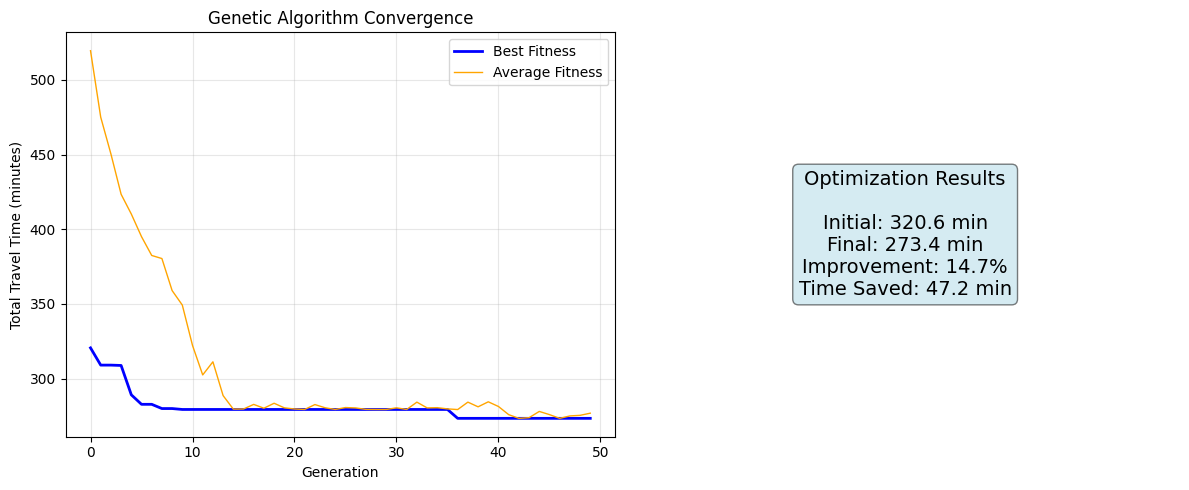

In [37]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(best_history, label='Best Fitness', color='blue', linewidth=2)
plt.plot(avg_history, label='Average Fitness', color='orange', linewidth=1)
plt.xlabel('Generation')
plt.ylabel('Total Travel Time (minutes)')
plt.title('Genetic Algorithm Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
improvement = ((best_history[0] - best_history[-1]) / best_history[0]) * 100
plt.text(0.5, 0.5, f'Optimization Results\n\n'
         f'Initial: {best_history[0]:.1f} min\n'
         f'Final: {best_history[-1]:.1f} min\n'
         f'Improvement: {improvement:.1f}%\n'
         f'Time Saved: {best_history[0] - best_history[-1]:.1f} min',
         ha='center', va='center', fontsize=14, 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
plt.axis('off')

plt.tight_layout()
plt.savefig('../data/ga_performance.png', dpi=300, bbox_inches='tight')
plt.show()


In [38]:
route_coordinates = []
route_details = []

print("\nOptimized Route Sequence:")
print("="*60)

route_coordinates.append((starting_point['lat'], starting_point['lon']))
route_details.append({
    'sequence': 0,
    'store_name': 'Starting Point',
    'latitude': starting_point['lat'],
    'longitude': starting_point['lon'],
    'address': 'Depot/Warehouse',
    'weather': weather_data['start'].get('condition', 'Clear'),
    'temperature': weather_data['start'].get('temperature', 25),
    'time_to_next': dist_matrix[0][best_route[0]]
})

print(f"0. Starting Point")
print(f"   📍 Coordinates: ({starting_point['lat']:.4f}, {starting_point['lon']:.4f})")
print(f"   ⏱️ Time to first delivery: {dist_matrix[0][best_route[0]]:.1f} minutes")
print()

for i, idx in enumerate(best_route):
    location = locations_subset.iloc[idx-1] 
    coords = (location['Latitude'], location['Longitude'])
    weather = weather_data.get(idx-1, {})
    
    if i < len(best_route) - 1:
        next_idx = best_route[i + 1]
        time_to_next = dist_matrix[idx][next_idx]
    else:
        time_to_next = dist_matrix[idx][0]
    
    route_coordinates.append(coords)
    
    detail = {
        'sequence': i + 1,
        'store_name': location['Store Name'],
        'latitude': location['Latitude'],
        'longitude': location['Longitude'],
        'address': location['Street Address'],
        'weather': weather.get('condition', 'Clear'),
        'temperature': weather.get('temperature', 25),
        'time_to_next': time_to_next
    }
    route_details.append(detail)
    
    print(f"{i+1}. {location['Store Name']}")
    print(f"   📍 Coordinates: ({location['Latitude']:.4f}, {location['Longitude']:.4f})")
    print(f"   🌤️ Weather: {weather.get('condition', 'Clear')}, {weather.get('temperature', 25):.1f}°C")
    print(f"   ⏱️ Time to next: {time_to_next:.1f} minutes")
    print()

route_coordinates.append((starting_point['lat'], starting_point['lon']))

print("Return to Starting Point")
print(f"Total route time: {best_time:.1f} minutes ({best_time/60:.1f} hours)")

route_df = pd.DataFrame(route_details)
route_df.to_csv('../data/optimized_route_with_start.csv', index=False)
print(f"\nRoute saved to: ../data/optimized_route_with_start.csv")



Optimized Route Sequence:
0. Starting Point
   📍 Coordinates: (19.1974, 72.9907)
   ⏱️ Time to first delivery: 102.3 minutes

1. Fort
   📍 Coordinates: (18.9300, 72.8300)
   🌤️ Weather: Moderate or heavy rain shower, 26.3°C
   ⏱️ Time to next: 3.2 minutes

2. Nariman Point
   📍 Coordinates: (18.9300, 72.8200)
   🌤️ Weather: Moderate or heavy rain shower, 26.3°C
   ⏱️ Time to next: 26.6 minutes

3. Prabhadevi
   📍 Coordinates: (19.0100, 72.8200)
   🌤️ Weather: Moderate or heavy rain shower, 26.3°C
   ⏱️ Time to next: 13.7 minutes

4. Bandra West - Chapel road
   📍 Coordinates: (19.0500, 72.8300)
   🌤️ Weather: Moderate or heavy rain shower, 26.3°C
   ⏱️ Time to next: 8.9 minutes

5. Santacruz West
   📍 Coordinates: (19.0800, 72.8300)
   🌤️ Weather: Moderate or heavy rain shower, 26.3°C
   ⏱️ Time to next: 16.0 minutes

6. Andheri West - Four Bunglows
   📍 Coordinates: (19.1300, 72.8200)
   🌤️ Weather: Moderate or heavy rain shower, 26.3°C
   ⏱️ Time to next: 4.2 minutes

7. Andheri Wes

In [50]:
def create_optimized_route_map_with_roads(route, locations, starting_point, distance_matrix, weather_conditions):
    """Create an interactive map showing the actual road routes"""
    
    # Calculate center
    all_lats = [starting_point['lat']] + list(locations['Latitude'])
    all_lons = [starting_point['lon']] + list(locations['Longitude'])
    center_lat = np.mean(all_lats)
    center_lon = np.mean(all_lons)
    
    # Create map
    route_map = folium.Map(
        location=[center_lat, center_lon], 
        zoom_start=12,
        tiles='OpenStreetMap'
    )
    
    # Store all route segments
    all_route_segments = []
    route_success_count = 0
    
    # Add starting point marker
    folium.Marker(
        location=[starting_point['lat'], starting_point['lon']],
        popup=folium.Popup("Starting Point (Depot/Warehouse)", max_width=300),
        tooltip="Starting Point",
        icon=folium.Icon(color='red', icon='home', prefix='fa')
    ).add_to(route_map)
    
    # Add delivery location markers with numbers
    for i, idx in enumerate(route):
        location = locations.iloc[idx-1]
        weather = weather_conditions.get(idx-1, {})
        
        # Determine marker color based on weather
        if weather.get('condition', '') in ['Rain', 'Heavy Rain']:
            color = 'darkred'
        elif weather.get('condition', '') in ['Cloudy', 'Mist']:
            color = 'orange'
        else:
            color = 'green'
        
        popup_text = f"""
        <b>Stop {i + 1}: {location['Store Name']}</b><br>
        <b>Address:</b> {location['Street Address']}<br>
        <b>Weather:</b> {weather.get('condition', 'Clear')}, {weather.get('temperature', 25):.1f}°C<br>
        """
        
        # Add location marker
        folium.Marker(
            location=[location['Latitude'], location['Longitude']],
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=f"Stop {i + 1}: {location['Store Name']}",
            icon=folium.Icon(color=color, icon='coffee', prefix='fa')
        ).add_to(route_map)
        
        # Add number overlay
        folium.Marker(
            location=[location['Latitude'], location['Longitude']],
            icon=folium.DivIcon(
                html=f'''<div style="font-size: 12pt; font-weight: bold; color: white; 
                background-color: blue; width: 25px; height: 25px; 
                border-radius: 50%; text-align: center; 
                line-height: 25px; margin-top: -35px; margin-left: 5px;">{i + 1}</div>'''
            )
        ).add_to(route_map)
    
    # Create complete route waypoints
    waypoints = [[starting_point['lat'], starting_point['lon']]]
    for idx in route:
        loc = locations.iloc[idx-1]
        waypoints.append([loc['Latitude'], loc['Longitude']])
    waypoints.append([starting_point['lat'], starting_point['lon']])
    
    print("Getting actual road routes...")
    
    # Process each segment
    for i in range(len(waypoints) - 1):
        origin = waypoints[i]
        destination = waypoints[i + 1]
        
        # Determine segment name
        if i == 0:
            segment_name = f"Start → Stop 1"
        elif i == len(route):
            segment_name = f"Stop {i} → Start (Return)"
        else:
            segment_name = f"Stop {i} → Stop {i+1}"
        
        print(f"Processing {segment_name}...")
        
        # Get directions
        directions = get_directions_route(
            origin[0], origin[1],
            destination[0], destination[1]
        )
        
        if directions and directions['route_points']:
            route_success_count += 1
            
            # Determine color based on duration
            duration = directions['duration']
            if duration > 30:
                line_color = '#8B0000'  # Dark red
                weight = 6
            elif duration > 20:
                line_color = '#FF8C00'  # Dark orange
                weight = 5
            else:
                line_color = '#228B22'  # Forest green
                weight = 4
            
            # Special color for return route
            if i == len(route):
                line_color = '#9370DB'  # Medium purple
                weight = 4
            
            # Draw the actual road route
            route_line = folium.PolyLine(
                locations=directions['route_points'],
                color=line_color,
                weight=weight,
                opacity=0.8,
                popup=folium.Popup(
                    f"{segment_name}<br>"
                    f"Distance: {directions['distance']:.1f} km<br>"
                    f"Time: {directions['duration']:.1f} min",
                    max_width=200
                ),
                tooltip=f"{segment_name}: {directions['duration']:.1f} min"
            ).add_to(route_map)
            
            # Add direction arrow at midpoint
            if len(directions['route_points']) > 2:
                mid_idx = len(directions['route_points']) // 2
                mid_point = directions['route_points'][mid_idx]
                
                folium.RegularPolygonMarker(
                    location=mid_point,
                    number_of_sides=3,
                    radius=8,
                    rotation=45,
                    color=line_color,
                    fill=True,
                    fillColor=line_color,
                    fillOpacity=0.4
                ).add_to(route_map)
            
            all_route_segments.extend(directions['route_points'])
            
        else:
            # Fallback: Draw straight line if directions fail
            print(f"  ⚠️ Directions API failed for {segment_name}, using straight line")
            
            folium.PolyLine(
                locations=[origin, destination],
                color='gray',
                weight=3,
                opacity=0.5,
                dash_array='10, 10',
                popup=f"{segment_name} (Direct line - API failed)"
            ).add_to(route_map)
        
        # Small delay to respect API limits
        time.sleep(0.3)
    
    print(f"\nSuccessfully retrieved {route_success_count}/{len(waypoints)-1} route segments")
    
    # Add enhanced legend
    legend_html = f'''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 320px; height: auto; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 15px; border-radius: 5px;
                box-shadow: 0 2px 5px rgba(0,0,0,0.3);">
        <h4 style="margin: 0 0 10px 0;">Route Information</h4>
        <p style="margin: 5px 0;"><b>Starting Point:</b> Depot/Warehouse</p>
        <p style="margin: 5px 0;"><b>Delivery Stops:</b> {len(route)}</p>
        <p style="margin: 5px 0;"><b>Total Time:</b> {best_time:.1f} min ({best_time/60:.1f} hrs)</p>
        <p style="margin: 5px 0;"><b>Route Segments:</b> {route_success_count} of {len(waypoints)-1}</p>
        <hr style="margin: 10px 0;">
        <p style="margin: 5px 0;"><b>Route Colors:</b></p>
        <p style="margin: 3px 0 3px 15px;"><span style="color: #228B22;">━━</span> Fast (&lt;20 min)</p>
        <p style="margin: 3px 0 3px 15px;"><span style="color: #FF8C00;">━━</span> Moderate (20-30 min)</p>
        <p style="margin: 3px 0 3px 15px;"><span style="color: #8B0000;">━━</span> Slow (&gt;30 min)</p>
        <p style="margin: 3px 0 3px 15px;"><span style="color: #9370DB;">━━</span> Return to Start</p>
        <p style="margin: 3px 0 3px 15px;"><span style="color: gray;">┅┅</span> Direct line (API failed)</p>
        <hr style="margin: 10px 0;">
        <p style="margin: 5px 0; font-size: 12px; color: #666;">
            <b>Note:</b> Routes follow actual roads via Google Directions API
        </p>
    </div>
    '''
    route_map.get_root().html.add_child(folium.Element(legend_html))
    
    # Add a button to view in Google Maps
    gmaps_url = "https://www.google.com/maps/dir/"
    for wp in waypoints:
        gmaps_url += f"{wp[0]},{wp[1]}/"
    
    button_html = f'''
    <div style="position: fixed; 
                top: 10px; right: 10px; 
                z-index: 9999;">
        <a href="{gmaps_url}" target="_blank" 
           style="display: inline-block; background-color: #4285f4; color: white; 
                  padding: 10px 20px; text-decoration: none; border-radius: 5px; 
                  font-size: 14px; font-weight: bold; box-shadow: 0 2px 5px rgba(0,0,0,0.3);">
            📍 Open in Google Maps
        </a>
    </div>
    '''
    route_map.get_root().html.add_child(folium.Element(button_html))
    
    return route_map, all_route_segments

# Create and save optimized route map with actual roads
print("Creating route map with actual road paths...")
optimized_map, route_segments = create_optimized_route_map_with_roads(
    best_route, locations_subset, starting_point, dist_matrix, weather_data
)
optimized_map.save('../data/optimized_route_map_with_roads.html')
print(f"Total route segments: {len(route_segments)}")
print("Optimized route map with actual roads saved to: ../data/optimized_route_map_with_roads.html")
optimized_map

      
        
       

       


Creating route map with actual road paths...
Getting actual road routes...
Processing Start → Stop 1...
API Status: REQUEST_DENIED
Error: The provided API key is invalid. 
  ⚠️ Directions API failed for Start → Stop 1, using straight line
Processing Stop 1 → Stop 2...
API Status: REQUEST_DENIED
Error: The provided API key is invalid. 
  ⚠️ Directions API failed for Stop 1 → Stop 2, using straight line
Processing Stop 2 → Stop 3...
API Status: REQUEST_DENIED
Error: The provided API key is invalid. 
  ⚠️ Directions API failed for Stop 2 → Stop 3, using straight line
Processing Stop 3 → Stop 4...
API Status: REQUEST_DENIED
Error: The provided API key is invalid. 
  ⚠️ Directions API failed for Stop 3 → Stop 4, using straight line
Processing Stop 4 → Stop 5...
API Status: REQUEST_DENIED
Error: The provided API key is invalid. 
  ⚠️ Directions API failed for Stop 4 → Stop 5, using straight line
Processing Stop 5 → Stop 6...
API Status: REQUEST_DENIED
Error: The provided API key is invalid. 

In [41]:
final_report = {
    'optimization_summary': {
        'algorithm': 'XGBoost + Genetic Algorithm',
        'starting_point': {
            'latitude': starting_point['lat'],
            'longitude': starting_point['lon'],
            'description': 'Depot/Warehouse'
        },
        'total_delivery_locations': len(best_route),
        'total_travel_time_minutes': best_time,
        'total_travel_time_hours': best_time / 60,
        'optimization_improvement': f"{((best_history[0] - best_history[-1]) / best_history[0]) * 100:.1f}%",
        'generation_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    },
    'model_performance': {
        'xgboost_r2_score': r2,
        'xgboost_rmse': rmse,
        'training_samples': len(training_df),
        'features_used': feature_columns
    },
    'route_sequence': route_details,
    'coordinates_list': route_coordinates,
    'weather_conditions': weather_data
}

with open('../data/final_route_report_with_start.json', 'w') as f:
    json.dump(final_report, f, indent=2)

print("\n" + "="*60)
print("FINAL OPTIMIZED ROUTE REPORT")
print("="*60)
print(f"\n📊 Algorithm: XGBoost (prediction) + Genetic Algorithm (optimization)")
print(f"🏠 Starting Point: ({starting_point['lat']:.4f}, {starting_point['lon']:.4f})")
print(f"📍 Delivery Locations: {len(best_route)}")
print(f"⏱️ Total Travel Time: {best_time:.1f} minutes ({best_time/60:.1f} hours)")
print(f"📈 Optimization Improvement: {((best_history[0] - best_history[-1]) / best_history[0]) * 100:.1f}%")
print(f"🎯 XGBoost Model Accuracy: R² = {r2:.3f}")
print(f"\n✅ Optimization considers:")
print("   - Starting from specific depot/warehouse location")
print("   - Real-time traffic patterns (learned by XGBoost)")
print("   - Current weather conditions")
print("   - Efficient route back to starting point")


FINAL OPTIMIZED ROUTE REPORT

📊 Algorithm: XGBoost (prediction) + Genetic Algorithm (optimization)
🏠 Starting Point: (19.1974, 72.9907)
📍 Delivery Locations: 10
⏱️ Total Travel Time: 273.4 minutes (4.6 hours)
📈 Optimization Improvement: 14.7%
🎯 XGBoost Model Accuracy: R² = 0.999

✅ Optimization considers:
   - Starting from specific depot/warehouse location
   - Real-time traffic patterns (learned by XGBoost)
   - Current weather conditions
   - Efficient route back to starting point


In [42]:
def optimize_user_input_locations(user_coords_list, starting_point_input):
    """
    Function to handle user-provided coordinates with a starting point
    user_coords_list: List of delivery location tuples [(lat1, lon1), (lat2, lon2), ...]
    starting_point_input: Dictionary with starting point {'lat': lat, 'lon': lon}
    """
    print(f"Optimizing route from starting point: ({starting_point_input['lat']}, {starting_point_input['lon']})")
    print(f"Number of delivery locations: {len(user_coords_list)}")
    
    user_locations = pd.DataFrame([
        {'Latitude': lat, 'Longitude': lon, 'Store Name': f'Delivery Location {i+1}'}
        for i, (lat, lon) in enumerate(user_coords_list)
    ])
    
    user_dist_matrix, user_weather = create_distance_matrix_with_start(
        user_locations, starting_point_input, xgb_model, scaler
    )
    
    user_optimizer = RouteOptimizerWithStart(user_dist_matrix, user_weather)
    user_route, user_time, _, _ = user_optimizer.evolve(
        population_size=50, generations=30
    )
    
    optimized_coords = []
    
    optimized_coords.append((starting_point_input['lat'], starting_point_input['lon']))
    
    for idx in user_route:
        optimized_coords.append(user_coords_list[idx-1])  
    
    optimized_coords.append((starting_point_input['lat'], starting_point_input['lon']))
    
    return optimized_coords, user_time, user_route

example_starting_point = {
    'lat': 22.288904251300554,  #parul
    'lon': 73.36332383490112
}

example_delivery_locations = [
    (22.29457821635284, 73.26508269442095),  # Location 1
    (22.301175706877416, 73.25458916607523),  # Location 2
    (22.293920953642647, 73.24263545818228),  # Location 3
    (22.295469534455155, 73.23791477055862),  # Location 4
    (22.29920194075179, 73.2477852992263), #location 5
]

print("Example: Optimizing route for user-provided locations...")
user_optimized_coords, user_total_time, user_route_order = optimize_user_input_locations(
    example_delivery_locations, 
    example_starting_point
)

print(f"\nOptimized route:")
print(f"Total travel time: {user_total_time:.1f} minutes ({user_total_time/60:.1f} hours)")
print("\nOptimized coordinate sequence:")
for i, coords in enumerate(user_optimized_coords):
    if i == 0:
        print(f"{i}. Starting Point: ({coords[0]:.4f}, {coords[1]:.4f})")
    elif i == len(user_optimized_coords) - 1:
        print(f"{i}. Return to Start: ({coords[0]:.4f}, {coords[1]:.4f})")
    else:
        print(f"{i}. Delivery Location {user_route_order[i-1]}: ({coords[0]:.4f}, {coords[1]:.4f})")

user_map = folium.Map(location=[example_starting_point['lat'], example_starting_point['lon']], zoom_start=11)

for i, coords in enumerate(user_optimized_coords[:-1]):
    if i == 0:
        folium.Marker(
            location=coords,
            popup="Starting Point",
            icon=folium.Icon(color='red', icon='home')
        ).add_to(user_map)
    else:
        folium.Marker(
            location=coords,
            popup=f"Delivery {i}",
            icon=folium.Icon(color='green', icon='info-sign')
        ).add_to(user_map)

folium.PolyLine(
    locations=user_optimized_coords,
    color='blue',
    weight=4,
    opacity=0.8
).add_to(user_map)

user_map

       


Example: Optimizing route for user-provided locations...
Optimizing route from starting point: (22.288904251300554, 73.36332383490112)
Number of delivery locations: 5
Creating distance matrix for 5 locations plus starting point...
Processed 5/5 locations
Starting genetic algorithm optimization...
Route will start and end at the starting point
Generation 0: Best fitness = 79.43 min
Generation 10: Best fitness = 79.43 min
Generation 20: Best fitness = 79.43 min

Optimized route:
Total travel time: 79.4 minutes (1.3 hours)

Optimized coordinate sequence:
0. Starting Point: (22.2889, 73.3633)
1. Delivery Location 5: (22.2992, 73.2478)
2. Delivery Location 4: (22.2955, 73.2379)
3. Delivery Location 3: (22.2939, 73.2426)
4. Delivery Location 2: (22.3012, 73.2546)
5. Delivery Location 1: (22.2946, 73.2651)
6. Return to Start: (22.2889, 73.3633)
